<a href="https://colab.research.google.com/github/mrarat76/Tensorflow_Practises/blob/main/Tensor_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##Tensor Transfer Learning: Özellik Çıkarımı

In [ ]:
!nvidia-smi

Sun Oct 29 12:12:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Transfer Learning**
Datanın %10 kısmıyla mğkemmel sonuçlar alınabilir.

In [ ]:
# Data çekme (%10)
import zipfile


!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip işlemi
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-10-29 12:12:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.207, 209.85.234.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   145MB/s    in 1.1s    

2023-10-29 12:12:48 (145 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Fotoğraf sayısı belirleme.
import os

# Yüzde 10'luk veri dizini ve dosya sayısını listelenmesi
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

# **Veri yükleyicilerin oluşturulması (verilerin hazırlanması)**

In [ ]:
# Data girişlerinin setlenmesi
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [ ]:
#Tensorboard callback oluştuma (her model için yeni bir tane oluşturulması gerektiğinden işlevsel hale getiriyoruz)

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


# **Tensorflow Hub kullanarak Model Oluşturma**

İki adet model kullanacağız Tensorflowdan,
ResnetV2 ve EfficentNet (İkisi de computer vision mimarileridir)



1. **"As Is" Transfer Öğrenme**: Bu yöntemde, önceden eğitilmiş bir modeli olduğu gibi kullanırsınız. Modelin tüm ağırlıkları ve yapıları değiştirilmeden kalır. Örneğin, bir model ImageNet veri kümesi üzerinde eğitilmişse, bu modeli başka bir görev için kullanabilirsiniz, ancak bu yeni görevdeki sınıf sayısına veya veri türüne uygun hale getirmek için herhangi bir değişiklik yapmazsınız.

2. **Özellik Çıkarma Transfer Öğrenme**: Bu yöntemde, önceden eğitilmiş bir modelin altta yatan desenlerini (ağırlıkları) alıp, bu desenleri yeni bir görev veya veri kümesine daha uygun hale getirirsiniz. Genellikle, modelin en üst katmanını değiştirir ve bu yeni katmanı, yeni görev için gerekli sayıda çıkış sınıfına sahip olacak şekilde yapılandırırsınız. Önemli olan, yalnızca en üstteki birkaç katmanın eğitilebilir hale gelmesidir, geri kalan katmanlar dondurulur veya sabitlenir. Bu, önceden eğitilmiş modelin altındaki desenlerin yeni veri kümesi için kullanılmasını sağlar.

3. **İnce Ayar Transfer Öğrenme**: Bu yöntemde, önceden eğitilmiş bir modelin altta yatan desenlerini (ağırlıkları) alır ve bu desenleri yeni bir göreve uygun hale getirmek için modelin bazı veya tüm katmanlarını eğitirsiniz. Genellikle, modelin alt katmanlarını dondurarak veya "dondurarak" bu katmanların eğitilmez hale gelmesini sağlarsınız. Sonra, modelin üstündeki birkaç katmanı, yeni veri kümesine daha uygun hale getirmek için eğitirsiniz. İlk olarak, yalnızca üst 2-3 katman eğitilir, daha sonra daha fazla katmanın "dondurulduğu" bir ince ayar süreci gerçekleştirilir.

Bu yöntemler, önceden eğitilmiş modelleri yeni görevler için uyarlarken kullanılan yaygın transfer öğrenme stratejileridir. "Özellik çıkarma" ve "ince ayar" yaklaşımları, veri kümenizin ve yeni görevinizin ihtiyaçlarına bağlı olarak seçilen yöntemlerdir.



In [ ]:
import tensorflow as tf
import tensorflow_hub as hub ## Tensorflow hub
from tensorflow.keras import layers

In [ ]:

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
def create_model(model_url, num_classes=10):
  """Aşağıdaki kod bir TensorFlow Hub URL'si alır ve onunla bir Keras Sıralı model oluşturur.

Args:

model_url (str): Bir TensorFlow Hub özellik çıkarma URL'si.
num_classes (int): Çıkış katmanındaki çıkış nöron sayısı, hedef sınıfların sayısına eşit olmalıdır, varsayılan olarak 10.
Return:

model_url'un özellik çıkartma katmanı ve num_classes çıkışına sahip, derlenmemiş bir Keras Sıralı model.
  """
  # Önceden eğitilmiş modeli indirilmesi ve Keras katmanı olarak kaydedilmesi
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Alt katmanların dondurullması
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # Inputta verilen fotoğrafın shapenin belirtilmesi

  # Model yapımı
  model = tf.keras.Sequential([
    feature_extractor_layer, # Feature extraction katmanını temel olarak kullanılması
    layers.Dense(num_classes, activation='softmax', name='output_layer') # Kendi output layerımızn oluşturulması
  ])

  return model



In [ ]:
# Model oluşturma
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Derleme
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Model fitlenmesi
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231029-121306
Epoch 1/5
24/24 [==============================] - 26s 612ms/step - loss: 1.8441 - accuracy: 0.3800 - val_loss: 1.1701 - val_accuracy: 0.6404
Epoch 2/5
24/24 [==============================] - 13s 565ms/step - loss: 0.8795 - accuracy: 0.7267 - val_loss: 0.8635 - val_accuracy: 0.7220
Epoch 3/5
24/24 [==============================] - 11s 469ms/step - loss: 0.6115 - accuracy: 0.8227 - val_loss: 0.7690 - val_accuracy: 0.7504
Epoch 4/5
24/24 [==============================] - 12s 502ms/step - loss: 0.4799 - accuracy: 0.8733 - val_loss: 0.7030 - val_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 11s 463ms/step - loss: 0.3680 - accuracy: 0.9120 - val_loss: 0.6677 - val_accuracy: 0.7792


In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


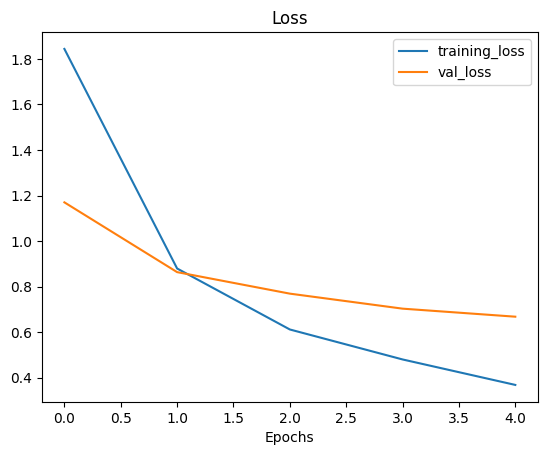

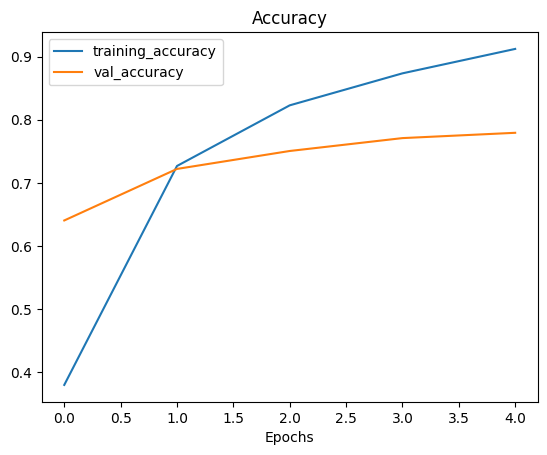

In [ ]:
plot_loss_curves(resnet_history)


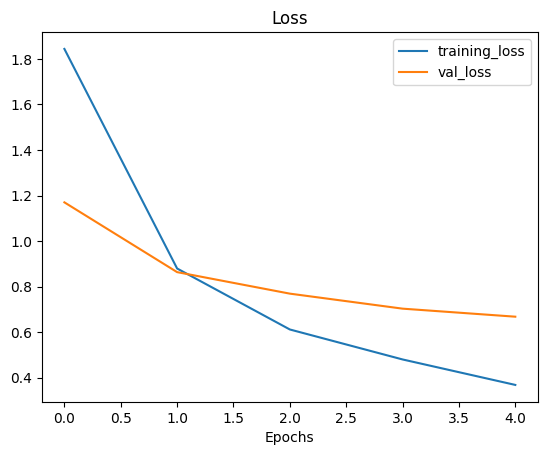

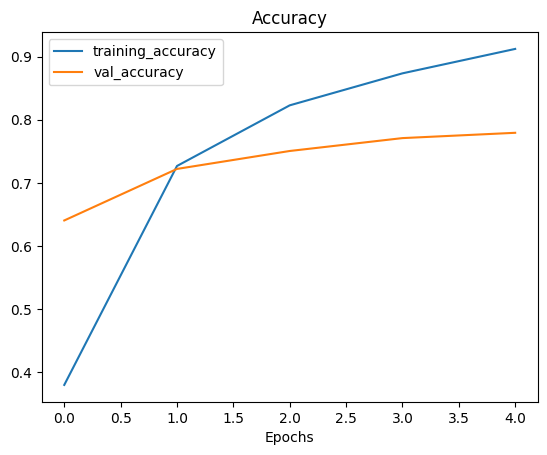

In [ ]:
plot_loss_curves(resnet_history)


In [ ]:
# Model create
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20231029-121507
Epoch 1/5
24/24 [==============================] - 22s 516ms/step - loss: 1.9209 - accuracy: 0.3787 - val_loss: 1.3537 - val_accuracy: 0.7112
Epoch 2/5
24/24 [==============================] - 10s 443ms/step - loss: 1.1089 - accuracy: 0.7533 - val_loss: 0.8927 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 10s 437ms/step - loss: 0.7896 - accuracy: 0.8160 - val_loss: 0.7132 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 10s 432ms/step - loss: 0.6273 - accuracy: 0.8640 - val_loss: 0.6206 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 10s 427ms/step - loss: 0.5279 - accuracy: 0.8840 - val_loss: 0.5644 - val_accuracy: 0.8580


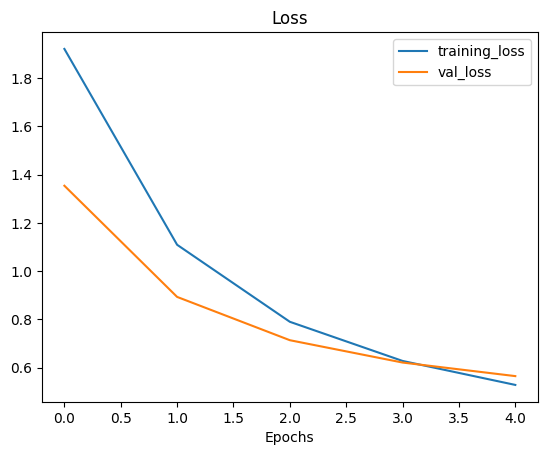

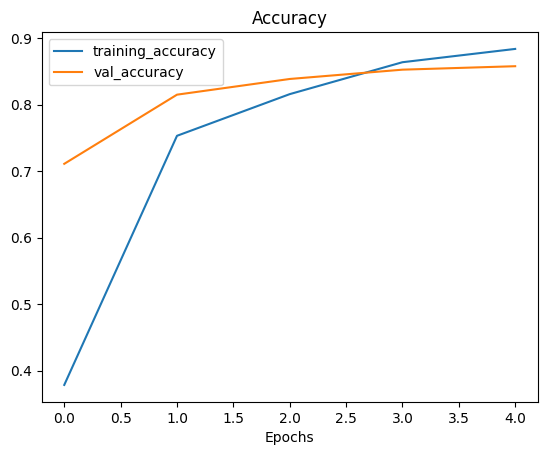

In [ ]:
plot_loss_curves(efficientnet_history)


In [ ]:
efficientnet_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:

# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-10-29 12:16:19.599878: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 12:16:19.599944: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 12:16:19.599993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 12:16:20.598808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use 